In [13]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

In [14]:
# Dataset class
class HeartDataset(Dataset):
    def __init__(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# Model class
class DeepHeartNet(nn.Module):
    def __init__(self, input_dim):
        super(DeepHeartNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)    

In [15]:
# Data preparation
data_path = '/project/zhiwei/hf78/ecg/data/heart/heart.csv'
data = pd.read_csv(data_path)
X = data.drop('target', axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training and evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = HeartDataset(X_train_scaled, y_train)
test_dataset = HeartDataset(X_test_scaled, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

input_dim = X_train.shape[1]
model = DeepHeartNet(input_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

In [16]:
# Training loop
n_epochs = 200
best_loss = float('inf')
patience = 20
no_improve = 0
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device).view(-1, 1)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device).view(-1, 1)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    accuracy = 100 * correct / total
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(accuracy)
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    scheduler.step(avg_val_loss)
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered")
            break

Epoch 0: Train Loss: 0.5082, Val Loss: 0.3765, Accuracy: 84.39%
Epoch 10: Train Loss: 0.1719, Val Loss: 0.1376, Accuracy: 93.17%
Epoch 20: Train Loss: 0.1206, Val Loss: 0.0699, Accuracy: 99.51%
Epoch 30: Train Loss: 0.0802, Val Loss: 0.0399, Accuracy: 100.00%
Epoch 40: Train Loss: 0.0701, Val Loss: 0.0242, Accuracy: 100.00%
Epoch 50: Train Loss: 0.0667, Val Loss: 0.0168, Accuracy: 100.00%
Epoch 60: Train Loss: 0.0486, Val Loss: 0.0192, Accuracy: 98.54%
Epoch 70: Train Loss: 0.0646, Val Loss: 0.0100, Accuracy: 100.00%
Epoch 00072: reducing learning rate of group 0 to 5.0000e-04.
Epoch 80: Train Loss: 0.0384, Val Loss: 0.0045, Accuracy: 100.00%
Epoch 90: Train Loss: 0.0258, Val Loss: 0.0031, Accuracy: 100.00%
Epoch 00095: reducing learning rate of group 0 to 2.5000e-04.
Epoch 100: Train Loss: 0.0229, Val Loss: 0.0023, Accuracy: 100.00%
Epoch 00101: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00107: reducing learning rate of group 0 to 6.2500e-05.
Early stopping triggered


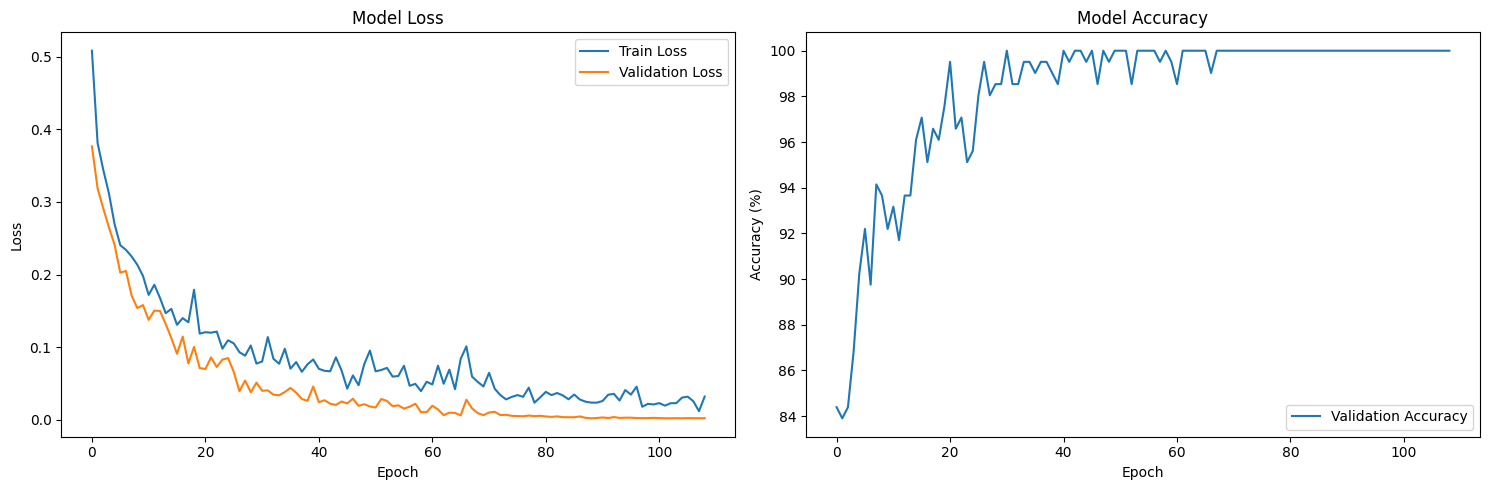

In [17]:
# Plotting training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



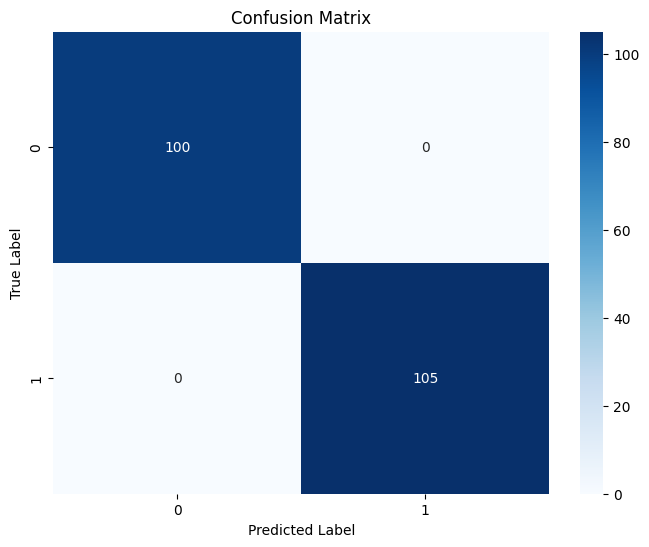

'\n# ROC curve\nfpr, tpr, _ = roc_curve(y_test, all_probs)\nroc_auc = auc(fpr, tpr)\n\nplt.figure(figsize=(8, 6))\nplt.plot(fpr, tpr, color=\'darkorange\', lw=2, label=f\'ROC curve (AUC = {roc_auc:.2f})\')\nplt.plot([0, 1], [0, 1], color=\'navy\', lw=2, linestyle=\'--\')\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True Positive Rate\')\nplt.title(\'Receiver Operating Characteristic (ROC)\')\nplt.legend(loc="lower right")\nplt.show()\n'

In [18]:
# Model evaluation
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
all_preds, all_probs = [], []

with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        probs = outputs.cpu().numpy()
        preds = (outputs > 0.5).float().cpu().numpy()
        all_probs.extend(probs)
        all_preds.extend(preds)

all_preds = np.array(all_preds).flatten()
all_probs = np.array(all_probs).flatten()
report = classification_report(y_test, all_preds)
print("\nClassification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(y_test, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

'''
# ROC curve
fpr, tpr, _ = roc_curve(y_test, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
'''